In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import math

with open('pga.pickle', 'rb') as file:
    g = pickle.load(file)

#Log Transform on 'money'
g['logmoney'] = g['money'].apply(lambda x: math.log(x)) 

In [2]:
#For All minus obvious features
g_small = g.drop(['Average Score', 'Points', 'Top 10', 'Average SG Total', 'Year','name'], axis=1)

#For All minus obvious features AND minus more features based on lasso and ridge
g_smaller = g.drop(['Avg Distance','height_inches', 'weight_lbs', 'Fairway Percentage','Average Score', 'Points', 'Top 10', 'Average SG Total', 'Year','name'], axis=1)

#no SG features
g_noSG = g.drop(['Average Score', 'Points', 'Top 10', 'Average SG Total', 'Year','name', 'Average SG Putts', 'SG:OTT', 'SG:APR','SG:ARG'], axis=1)

#only SG features
g_onlySG = g[['logmoney','money','Rounds','Average SG Putts','SG:OTT','SG:APR','SG:ARG']]

#SG without rounds
g_pureSG = g[['logmoney','money','Average SG Putts','SG:OTT','SG:APR','SG:ARG']]

In [3]:
#Cross Validation Test RIDGE NOT SCALED
def cv_r2_scores(df, r_alpha):

    X, y = df.drop(['logmoney','money'], axis=1), df['logmoney']

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

    X, y = np.array(X), np.array(y)

    ###

    lm = LinearRegression()
    lm_reg = Ridge(alpha=r_alpha)

    kf = KFold(n_splits=5, shuffle=True, random_state = 10)
    cvs = cross_val_score(lm, X, y, cv=kf, scoring='r2')
    cvs_ridge = cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')

    print('cross validation scores simple: ', cvs)
    print('cross validation scores ridge: ', cvs_ridge)

    print('mean c_v_s score simple reg: ', np.mean(cvs))
    print('mean c_v_s score ridge: ', np.mean(cvs_ridge))

In [4]:
#CV Test with errors Ridge SCALED and poly 2
def cv_errors(df, r_alpha):

    X, y = df.drop(['logmoney','money'], axis=1), df['logmoney']

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

    X, y = np.array(X), np.array(y)

    ###

    kf = KFold(n_splits=5, shuffle=True, random_state = 10)
    cv_lm_r2s, cv_lm_reg_r2s, cv_poly_r2s = [], [], []
    lm_train, lm_reg_train, poly_train = [], [], []

    for train_ind, val_ind in kf.split(X,y):
        
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
        lm_train.append(lm.score(X_train, y_train))

        #ridge with feature scaling
        lm_reg = Ridge(alpha=r_alpha)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
        lm_reg_train.append(lm_reg.score(X_train_scaled, y_train))

        #polynomial regression with degree 2
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        lm_poly = LinearRegression()
        lm_poly.fit(X_train_poly, y_train)
        cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
        poly_train.append(lm_poly.score(X_train_poly, y_train))

    print(f'Simple mean train R^2: {np.mean(lm_train):.3f} +- {np.std(lm_train):.3f}')
    print(f'Simple mean cv R^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print('Simple rmse: ', math.sqrt(mean_squared_error(y_val, lm.predict(X_val))))

    print(f'Ridge scaled mean train R^2: {np.mean(lm_reg_train):.3f} +- {np.std(lm_reg_train):.3f}')
    print(f'Ridge scaled mean cv R^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print('Ridge scaled rmse: ', math.sqrt(mean_squared_error(y_val, lm_reg.predict(X_val_scaled))))

    print(f'Degree 2 polynomial regression train R^2: {np.mean(poly_train):.3f} +- {np.std(poly_train):.3f}')
    print(f'Degree 2 polynomial regression cv R^2: {np.mean(cv_poly_r2s):.3f} +- {np.std(cv_poly_r2s):.3f}')
    print('Degree 2 polynomial regression rmse: ', math.sqrt(mean_squared_error(y_val, lm_poly.predict(X_val_poly))))

In [5]:
cv_r2_scores(g_small, 10)

cross validation scores simple:  [0.75407154 0.76844866 0.73560261 0.72601415 0.68754787]
cross validation scores ridge:  [0.74715578 0.76467135 0.72178438 0.71175431 0.68038518]
mean c_v_s score simple reg:  0.7343369658672234
mean c_v_s score ridge:  0.7251502005196382


In [6]:
cv_errors(g_small, 100)

Simple mean train R^2: 0.746 +- 0.007
Simple mean cv R^2: 0.734 +- 0.028
Simple rmse:  0.48010613185772383
Ridge scaled mean train R^2: 0.733 +- 0.007
Ridge scaled mean cv R^2: 0.724 +- 0.029
Ridge scaled rmse:  0.48376143031988245
Degree 2 polynomial regression train R^2: 0.784 +- 0.007
Degree 2 polynomial regression cv R^2: 0.710 +- 0.025
Degree 2 polynomial regression rmse:  0.49010910940058366


In [7]:
cv_errors(g_smaller, 100)

Simple mean train R^2: 0.743 +- 0.007
Simple mean cv R^2: 0.732 +- 0.028
Simple rmse:  0.48218769836339914
Ridge scaled mean train R^2: 0.731 +- 0.007
Ridge scaled mean cv R^2: 0.722 +- 0.029
Ridge scaled rmse:  0.4843210511394871
Degree 2 polynomial regression train R^2: 0.296 +- 0.729
Degree 2 polynomial regression cv R^2: 0.152 +- 0.876
Degree 2 polynomial regression rmse:  0.467264062627119


In [8]:
cv_errors(g_noSG, 100)

Simple mean train R^2: 0.521 +- 0.012
Simple mean cv R^2: 0.503 +- 0.048
Simple rmse:  0.648791383812396
Ridge scaled mean train R^2: 0.507 +- 0.012
Ridge scaled mean cv R^2: 0.493 +- 0.030
Ridge scaled rmse:  0.6390264226126913
Degree 2 polynomial regression train R^2: 0.565 +- 0.008
Degree 2 polynomial regression cv R^2: 0.485 +- 0.037
Degree 2 polynomial regression rmse:  0.6527090722396075


In [9]:
cv_errors(g_onlySG, 100)

Simple mean train R^2: 0.705 +- 0.009
Simple mean cv R^2: 0.698 +- 0.038
Simple rmse:  0.5202901832780181
Ridge scaled mean train R^2: 0.700 +- 0.009
Ridge scaled mean cv R^2: 0.693 +- 0.037
Ridge scaled rmse:  0.5186963987162678
Degree 2 polynomial regression train R^2: 0.726 +- 0.009
Degree 2 polynomial regression cv R^2: 0.708 +- 0.035
Degree 2 polynomial regression rmse:  0.5066206797122699


In [10]:
cv_errors(g_pureSG, 100)

Simple mean train R^2: 0.670 +- 0.007
Simple mean cv R^2: 0.663 +- 0.025
Simple rmse:  0.5214598930535597
Ridge scaled mean train R^2: 0.663 +- 0.007
Ridge scaled mean cv R^2: 0.657 +- 0.029
Ridge scaled rmse:  0.5222641925338288
Degree 2 polynomial regression train R^2: 0.681 +- 0.008
Degree 2 polynomial regression cv R^2: 0.664 +- 0.028
Degree 2 polynomial regression rmse:  0.523526182295077


***
Simple linear regression is best model with g_small, now test set

In [11]:
X, y = g_small.drop(['logmoney','money'], axis=1), g_small['logmoney']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

X, y = np.array(X), np.array(y)


kf = KFold(n_splits=5, shuffle=True, random_state = 10)
cv_lm_r2s, cv_lm_reg_r2s = [], [] 
lm_train, lm_reg_train = [], []

for train_ind, val_ind in kf.split(X,y):
        
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
        
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    lm_train.append(lm.score(X_train, y_train))

print(f'Simple mean train r^2: {np.mean(lm_train):.3f} +- {np.std(lm_train):.3f}')
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print('Simple rmse: ', math.sqrt(mean_squared_error(y_val, lm.predict(X_val))))
print(f'Simple Regression test R^2: {lm.score(X_test, y_test)}')


Simple mean train r^2: 0.746 +- 0.007
Simple mean cv r^2: 0.734 +- 0.028
Simple rmse:  0.48010613185772383
Simple Regression test R^2: 0.7492495000806545


In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y_test, sm.add_constant(X_test))
results = model.fit()

results.summary()

/home/rob/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logmoney   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     71.08
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.26e-79
Time:                        20:49:47   Log-Likelihood:                -170.49
No. Observations:                 287   AIC:                             369.0
Df Residuals:                     273   BIC:                             420.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2853     10.096      0.028      0.977     -19.591      20.162
height_inches          0.0151      0.015      1.012      0.312      -0.014       0.044
weight_lbs             0.0004      0.002      0.218      0.827      -0.003       0.004
birthyear              0.0070      0.005      1.560      0.120      -0.002       0.016
Rounds                 0.0145      0.002      6.466      0.000       0.010       0.019
Fairway Percentage     0.0168      0.011      1.583      0.115      -0.004       0.038
Avg Distance           0.0125      0.007      1.776      0.077      -0.001       0.026
gir                   -0.0489      0.023     -2.090      0.038      -0.095      -0.003
Average Putts         -0.1637      0.130     -1.260      0.209      -0.420       0.092
Average Scrambling     0.0086      0.014      0.632      0.528      -0.018       0.035
Average SG Putts       0.8830      0.130      6.811      0.000       0.628       1.138
SG:OTT                 1.0330      0.140      7.402      0.000       0.758       1.308
SG:APR                 1.1354      0.102     11.107      0.000       0.934       1.337
SG:ARG                 0.6353      0.179      3.545      0.000       0.283       0.988
==============================================================================
Omnibus:                       10.399   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.491
Skew:                           0.452   Prob(JB):                      0.00527
Kurtosis:                       3.247   Cond. No.                     7.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Suspected multicollinearity due to overlapping categories, try onlySG

In [13]:
X, y = g_pureSG.drop(['logmoney','money'], axis=1), g_pureSG['logmoney']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

X, y = np.array(X), np.array(y)


kf = KFold(n_splits=5, shuffle=True, random_state = 10)
cv_lm_r2s, cv_lm_reg_r2s = [], [] 
lm_train, lm_reg_train = [], []

for train_ind, val_ind in kf.split(X,y):
        
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
        
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    lm_train.append(lm.score(X_train, y_train))

print(f'Simple mean train r^2: {np.mean(lm_train):.3f} +- {np.std(lm_train):.3f}')
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print('Simple rmse: ', math.sqrt(mean_squared_error(y_val, lm.predict(X_val))))
print(f'Simple Regression test R^2: {lm.score(X_test, y_test)}')

Simple mean train r^2: 0.670 +- 0.007
Simple mean cv r^2: 0.663 +- 0.025
Simple rmse:  0.5214598930535597
Simple Regression test R^2: 0.7063710362547345


In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y_test, sm.add_constant(X_test))
results = model.fit()

results.summary()

/home/rob/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logmoney   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     172.0
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           2.26e-74
Time:                        20:49:47   Log-Likelihood:                -205.32
No. Observations:                 287   AIC:                             420.6
Df Residuals:                     282   BIC:                             438.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.6702      0.032    427.561      0.000      13.607      13.733
Average SG Putts     1.2303      0.087     14.133      0.000       1.059       1.402
SG:OTT               1.1923      0.082     14.540      0.000       1.031       1.354
SG:APR               1.0684      0.093     11.446      0.000       0.885       1.252
SG:ARG               0.8210      0.152      5.416      0.000       0.523       1.119
==============================================================================
Omnibus:                        2.369   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.151
Skew:                           0.208   Prob(JB):                        0.341
Kurtosis:                       3.082   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

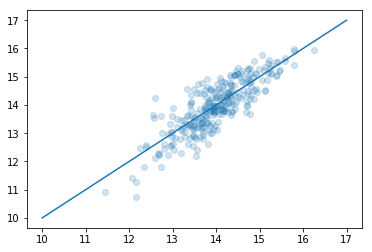

In [15]:
test_set_pred = lm.predict(X_test)
plt.scatter(test_set_pred, y_test, alpha=.2)
plt.plot(np.linspace(10,17,100), np.linspace(10,17,100))

In [16]:
lm.coef_

array([1.11736743, 1.17599467, 1.03319072, 0.91226236])

In [17]:
g.loc[g['name']=='Tiger Woods']

,money,name,height_inches,weight_lbs,birthyear,Rounds,Fairway Percentage,Year,Avg Distance,gir,...,Average Scrambling,Average Score,Points,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,logmoney
1432,5443841,Tiger Woods,73.0,185,1975,68.0,59.35,2018,303.6,67.40,...,64.16,69.350,1162,5.0,0.266,1.596,0.061,0.883,0.385,15.509995
1433,8553439,Tiger Woods,73.0,185,1975,61.0,62.50,2013,293.2,67.59,...,60.00,68.944,3059,7.0,0.426,2.064,-0.142,1.533,0.247,15.961844
1434,6133158,Tiger Woods,73.0,185,1975,69.0,63.93,2012,297.4,67.58,...,63.17,68.904,2269,6.0,0.339,2.310,0.553,1.224,0.194,15.629220


***
Reduce terms in degree 2 poly model

In [20]:
X, y = g_small.drop(['logmoney','money'], axis=1), g_small['logmoney']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

X, y = np.array(X), np.array(y)


kf = KFold(n_splits=5, shuffle=True, random_state = 10)
cv_poly_r2s = []
poly_train = []

for train_ind, val_ind in kf.split(X,y):
        
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    poly = PolynomialFeatures(degree=2)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_poly_scaled = poly.fit_transform(X_train_scaled)
    X_val_poly_scaled = poly.transform(X_val_scaled)
    
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly_scaled, y_train)
    cv_poly_r2s.append(lm_poly.score(X_val_poly_scaled, y_val))
    poly_train.append(lm_poly.score(X_train_poly_scaled, y_train))

print(f'Degree 2 polynomial regression train R^2: {np.mean(poly_train):.3f} +- {np.std(poly_train):.3f}')
print(f'Degree 2 polynomial regression cv R^2: {np.mean(cv_poly_r2s):.3f} +- {np.std(cv_poly_r2s):.3f}')
print('Degree 2 polynomial regression rmse: ', math.sqrt(mean_squared_error(y_val, lm_poly.predict(X_val_poly_scaled))))

Degree 2 polynomial regression train R^2: 0.784 +- 0.007
Degree 2 polynomial regression cv R^2: 0.710 +- 0.025
Degree 2 polynomial regression rmse:  0.49010910941848573


In [21]:
lasso_model = Lasso(alpha = .01)
lasso_model.fit(X_train_poly_scaled, y_train)
list(zip(poly.get_feature_names(), lasso_model.coef_))

[('1', 0.0),
 ('x0', -0.01528619961194311),
 ('x1', -0.0),
 ('x2', 0.03663222718300838),
 ('x3', 0.19371591815142958),
 ('x4', 0.0),
 ('x5', 0.0),
 ('x6', -0.0329487302639992),
 ('x7', -0.1383131585032631),
 ('x8', -0.1076903109675584),
 ('x9', 0.27813556764960595),
 ('x10', 0.4452059193691335),
 ('x11', 0.3986646652478496),
 ('x12', 0.20632283016575467),
 ('x0^2', -0.004655580712305553),
 ('x0 x1', -0.0),
 ('x0 x2', -0.0),
 ('x0 x3', 0.0),
 ('x0 x4', -0.0),
 ('x0 x5', 0.0),
 ('x0 x6', -0.0),
 ('x0 x7', -0.0),
 ('x0 x8', -0.017111564983634298),
 ('x0 x9', 0.0),
 ('x0 x10', -0.0),
 ('x0 x11', -0.0),
 ('x0 x12', 0.014719381266388148),
 ('x1^2', -0.009114298137724358),
 ('x1 x2', 0.007798337506277209),
 ('x1 x3', 0.0),
 ('x1 x4', -0.005077554851370292),
 ('x1 x5', 0.0),
 ('x1 x6', -0.0),
 ('x1 x7', 0.0),
 ('x1 x8', -0.0),
 ('x1 x9', -0.00916356831995398),
 ('x1 x10', -0.0),
 ('x1 x11', -0.0),
 ('x1 x12', 0.00045921838047758705),
 ('x2^2', -0.007929741012289456),
 ('x2 x3', 0.0),
 ('x2 x4'

In [22]:
from sklearn.pipeline import Pipeline

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_poly_scaled, y_train)
    
    val_set_pred = pipe.predict(X_val_poly_scaled)
    err_vec_val[i] = mae(y_val, val_set_pred)

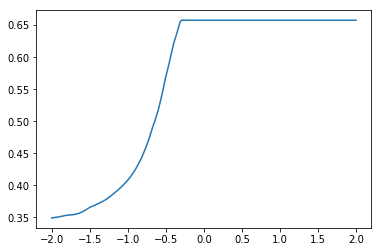

In [23]:
plt.plot(np.log10(alphalist), err_vec_val)

In [24]:
np.min(err_vec_val)

0.34934680940493607

In [25]:
alphalist[np.argmin(err_vec_val)]

0.01

In [26]:
X_test_scaled = scaler.transform(X_test)

X_test_poly_scaled = poly.transform(X_test_scaled)

test_set_pred = lm_poly.predict(X_test_poly_scaled)

r2_score(y_test, test_set_pred)

/home/rob/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


0.745075670022143

In [27]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)

lasso_model.fit(poly.fit_transform(scaler.fit_transform(X)), y)

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [28]:
lasso_model.alpha_

0.01

In [29]:
test_set_pred = lasso_model.predict(X_test_poly_scaled)

In [30]:
mae(y_test, test_set_pred)

0.3513561725754567

In [31]:
r2_score(y_test, test_set_pred)

0.7686618892984125

In [32]:
list(zip(poly.get_feature_names(), lasso_model.coef_))

[('1', 0.0),
 ('x0', -0.006226269670885879),
 ('x1', -0.0),
 ('x2', 0.06692300537655588),
 ('x3', 0.1772655444216453),
 ('x4', 0.0),
 ('x5', 0.0),
 ('x6', -0.04586846614913618),
 ('x7', -0.12031708572933592),
 ('x8', -0.09128259616813046),
 ('x9', 0.2678385773315928),
 ('x10', 0.4296816242941413),
 ('x11', 0.40346523709458737),
 ('x12', 0.1962417349976883),
 ('x0^2', -0.0),
 ('x0 x1', -0.0),
 ('x0 x2', -0.00430205342604529),
 ('x0 x3', 0.0),
 ('x0 x4', -0.0029640690299523012),
 ('x0 x5', 0.0),
 ('x0 x6', 0.0),
 ('x0 x7', 0.0),
 ('x0 x8', -0.014040356078598654),
 ('x0 x9', 0.0),
 ('x0 x10', 0.0),
 ('x0 x11', -0.0),
 ('x0 x12', 0.023366333473027124),
 ('x1^2', -0.004098887479933257),
 ('x1 x2', 0.004839446149781264),
 ('x1 x3', 0.0),
 ('x1 x4', -0.012711508787517038),
 ('x1 x5', 0.0),
 ('x1 x6', 0.0),
 ('x1 x7', 0.0),
 ('x1 x8', -0.007214360053488897),
 ('x1 x9', -0.00041896836272491876),
 ('x1 x10', -0.0),
 ('x1 x11', -0.004196126976010474),
 ('x1 x12', 0.006651894002764524),
 ('x2^2', 

***
**Run lasso on poly2 for final model**

In [33]:
X, y = g_small.drop(['logmoney','money'], axis=1), g_small['logmoney']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

X, y = np.array(X), np.array(y)

poly = PolynomialFeatures(degree=2)
    
scaler = StandardScaler()

X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

X_poly_scaled = scaler.fit_transform(X_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

lasso_model = Lasso(alpha = .01)
lasso_model.fit(X_poly_scaled, y)


print(f'Degree 2 polynomial regression train R^2: {lasso_model.score(X_poly_scaled, y):.3f}')
print(f'Degree 2 polynomial regression test R^2: {lasso_model.score(X_test_poly_scaled, y_test):.3f}')
print('Degree 2 polynomial regression rmse: ', math.sqrt(mean_squared_error(y_test, lasso_model.predict(X_test_poly_scaled))))

Degree 2 polynomial regression train R^2: 0.749
Degree 2 polynomial regression test R^2: 0.765
Degree 2 polynomial regression rmse:  0.42919020404003283


/home/rob/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [49]:
g.loc[g['name']=='Jordan Spieth']

,money,name,height_inches,weight_lbs,birthyear,Rounds,Fairway Percentage,Year,Avg Distance,gir,...,Average Scrambling,Average Score,Points,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,logmoney
1145,2793536,Jordan Spieth,73.0,175,1993,81.0,61.55,2018,299.8,70.47,...,61.63,69.904,945,5.0,-0.034,0.830,0.271,0.409,0.184,14.842819
1146,9433033,Jordan Spieth,73.0,175,1993,85.0,59.48,2017,295.0,69.97,...,61.75,68.846,2671,8.0,0.278,1.988,0.321,0.896,0.429,16.059728
1147,5538470,Jordan Spieth,73.0,175,1993,80.0,58.14,2016,295.4,63.52,...,63.93,69.520,1965,6.0,0.758,1.569,0.402,0.145,0.264,15.527229
1148,12030465,Jordan Spieth,73.0,175,1993,91.0,62.91,2015,291.8,67.87,...,65.03,68.938,4169,14.0,0.571,2.154,0.494,0.618,0.471,16.302953
1149,4342748,Jordan Spieth,73.0,175,1993,102.0,58.79,2014,289.7,62.47,...,62.39,69.946,1692,7.0,0.399,0.980,0.034,0.286,0.260,15.284018
1150,3879820,Jordan Spieth,73.0,175,1993,82.0,67.80,2013,289.4,66.94,...,61.07,69.668,1436,7.0,0.182,1.473,0.611,0.480,0.200,15.171299


In [50]:
test_input_x = scaler.transform(poly.transform(np.array(g_small.iloc[1145:1151,1:14])))

pred = list(lasso_model.predict(test_input_x))
print(pred)

[14.571368954069442, 15.954131176838038, 15.320125201340765, 16.22627906518549, 15.230484247699984, 15.39952844771656]


In [51]:
for x in pred:
    print(math.exp(x))

2129438.6408833493
8487721.747227877
4502418.25924359
11142520.963325817
4116378.1615511575
4874501.728815325


In [52]:
g['money'].iloc[1145:1151]

1145     2793536
1146     9433033
1147     5538470
1148    12030465
1149     4342748
1150     3879820
Name: money, dtype: int64

In [38]:
print('Degree 2 polynomial regression rmse: ', math.sqrt(mean_squared_error(np.exp(y), np.exp(lasso_model.predict(X_poly_scaled)))))

Degree 2 polynomial regression rmse:  746917.8201932714
